In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from operator import attrgetter
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from scipy.stats import chi2_contingency, ttest_ind

In [2]:
trancon1 = pd.read_csv("Проект_3_transactions_control_1.csv", sep=";", encoding='windows-1255', on_bad_lines='skip')
trancon2 = pd.read_csv("Проект_3_transactions_control_2.csv", sep=";", encoding='windows-1255', on_bad_lines='skip')
trantest = pd.read_csv("Проект_3_transactions_test.csv", sep=";", encoding='windows-1255', on_bad_lines='skip')
usercon1 = pd.read_csv("Проект_3_users_control_1.csv", sep=";", encoding='windows-1255', on_bad_lines='skip')
usercon2 = pd.read_csv("Проект_3_users_control_2.csv", sep=";", encoding='windows-1255', on_bad_lines='skip')
usertest = pd.read_csv("Проект_3_users_test.csv", sep=";", encoding='windows-1255', on_bad_lines='skip')

trantest['paid_at'] = pd.to_datetime(trantest['paid_at'], errors='coerce')
trancon1['paid_at'] = pd.to_datetime(trancon1['paid_at'], errors='coerce')
trancon2['paid_at'] = pd.to_datetime(trancon2['paid_at'], errors='coerce')
trantest['joined_at'] = pd.to_datetime(trantest['joined_at'], errors='coerce')
trancon1['joined_at'] = pd.to_datetime(trancon1['joined_at'], errors='coerce')
trancon2['joined_at'] = pd.to_datetime(trancon2['joined_at'], errors='coerce')
trancon1 = trancon1.dropna(subset=['uid'])
trancon1['uid'] = trancon1['uid'].astype(int)
trancon2['uid'] = trancon2['uid'].astype(int)
trantest['uid'] = trantest['uid'].astype(int)
usercon1['age'] = usercon1['age'].astype(int)
usercon2['age'] = usercon2['age'].astype(int)
usertest['age'] = usertest['age'].astype(int)

Проверим контрольные и тестовую группы на однородность и взаимную репрезентативность по разным параметрам колонок: пол, страна, возраст. Буду делить всё это на "заметки" для удобства.

Заметка №0 - после чистки NaN в 1 контрольной группе, выяснилось, что доля платящих людей в тестовой группе относительно других упала с 4.4% до 3.4%. Возможно нововведения негативно повлияли на готовность людей совершать транзакции.

In [3]:
print(f"Всего пользователей в 1 контрольной группе - {usercon1.uid.value_counts().count()}")
print(f"Платящих среди них - {trancon1.uid.value_counts().count()}. Это примерно {trancon1.uid.value_counts().count() / usercon1.uid.value_counts().count() * 100:.2f} %\n")
print(f"Всего пользователей во 2 контрольной группе - {usercon2.uid.value_counts().count()}")
print(f"Платящих среди них - {trancon2.uid.value_counts().count()}. Это примерно {trancon2.uid.value_counts().count() / usercon2.uid.value_counts().count() * 100:.2f} %\n")
print(f"Всего пользователей в тестовой группе - {usertest.uid.value_counts().count()}")
print(f"Платящих среди них - {trantest.uid.value_counts().count()}. Это примерно {trantest.uid.value_counts().count() / usertest.uid.value_counts().count() * 100:.2f} %\n")

Всего пользователей в 1 контрольной группе - 4340
Платящих среди них - 193. Это примерно 4.45 %

Всего пользователей во 2 контрольной группе - 4264
Платящих среди них - 187. Это примерно 4.39 %

Всего пользователей в тестовой группе - 4308
Платящих среди них - 146. Это примерно 3.39 %



Заметка №1 - гендерное распределение явно неравномерно. Исходя из того, что это дейтинг-приложение (и погуглив статистику), предположу что "1" это мужчины. Процентное соотношение их составляет...

In [4]:
print(f"Процент мужчин в 1-ой контрольной группе составляет {usercon1.gender.value_counts()[1] / (usercon1.gender.value_counts()[1] + usercon1.gender.value_counts()[0]) * 100:.2f} %")
print(f"Процент мужчин во 2-ой контрольной группе составляет {usercon2.gender.value_counts()[1] / (usercon2.gender.value_counts()[1] + usercon2.gender.value_counts()[0]) * 100:.2f} %")
print(f"Процент мужчин в тестовой группе  составляет {usertest.gender.value_counts()[1] / (usertest.gender.value_counts()[1] + usertest.gender.value_counts()[0]) * 100:.2f} %")

Процент мужчин в 1-ой контрольной группе составляет 95.81 %
Процент мужчин во 2-ой контрольной группе составляет 95.43 %
Процент мужчин в тестовой группе  составляет 95.31 %


Что ж, по крайней мере между собой они однородны в этом абсолютно неравномерном гендерном распределении. Наверное тут можно только не понять, но простить.

Заметка №2 - сегментация по странам - примерно одинаковая среди пользователей. Примерно треть из США, все остальные страны также примерно одинаково распределены во всех трёх группах. По крайней мере я не вижу причин рассматривать этот аспект более детально, поскольку хирургической точности в однородности географии добиться довольно тяжело да и не то чтобы нужно. Нынешняя статистика меня более чем удовлетворяет.

In [5]:
countries = pd.DataFrame()
countries['control_group_1'] = usercon1.country.value_counts()
countries['control_group_2'] = usercon2.country.value_counts()
countries['test_group'] = usertest.country.value_counts()
countries

,control_group_1,control_group_2,test_group
United States of America,1471,1486.0,1450.0
Argentina,389,397.0,396.0
France,370,376.0,359.0
Spain,342,310.0,301.0
Italy,338,293.0,323.0
Chile,287,286.0,272.0
United Arab Emirates,207,211.0,226.0
Germany,188,202.0,209.0
United Kingdom (Great Britain),146,146.0,169.0
Canada,134,134.0,137.0


Заметка №2.5 - ради интереса также решил проверить таблицы транзакций (убрав условных "транзакционных китов", совершивших несколько транзакций и сократив их до одного человека-транзакции). Таким образом среди платящих тоже наблюдается некий паритет, хотя в тестовой группе начинаю замечать некоторый спад. Повторно предполагаем негативный эффект нововведений. Но для этого требуется дальнейший анализ, так как не факт что большинство транзакций связаны с премиумом, я скорее смотрел просто активно платящих за что-либо в приложении.

In [6]:
countries2 = pd.DataFrame()
countries2['control_group_1'] = trancon1.drop_duplicates(subset='uid', keep='first').country.value_counts()
countries2['control_group_2'] = trancon2.drop_duplicates(subset='uid', keep='first').country.value_counts()
countries2['test_group'] = trantest.drop_duplicates(subset='uid', keep='first').country.value_counts()
countries2

,control_group_1,control_group_2,test_group
United States of America,60,64.0,52.0
France,22,19.0,13.0
Italy,17,16.0,9.0
Israel,14,6.0,5.0
Argentina,12,10.0,7.0
Chile,10,11.0,4.0
United Kingdom (Great Britain),10,10.0,8.0
Canada,9,4.0,6.0
Spain,9,12.0,15.0
United Arab Emirates,7,5.0,9.0


Заметка №3 - с возрастом тоже всё относительно гладко. 23/24-х летние слегка настораживают, но думаю это просто моя внутренняя обезьянья конкуренция (мне 24). В общем, возрастных аномалий пока не вижу, так что об этой колонке я пока что забуду. 

In [7]:
ages = pd.DataFrame()
ages['control_group_1'] = usercon1.age.value_counts()
ages['control_group_2'] = usercon2.age.value_counts()
ages['test_group'] = usertest.age.value_counts()
ages

,control_group_1,control_group_2,test_group
25,227,241.0,238.0
27,212,226.0,224.0
26,195,185.0,191.0
21,186,171.0,193.0
23,184,149.0,144.0
30,175,167.0,155.0
28,170,165.0,187.0
29,170,173.0,213.0
22,169,169.0,178.0
24,165,189.0,151.0


Переходим к транзакциям.

Заметка №4 - поглядим, что покупали на транзакции пользователи. Как можно заметить, монеты линейно падают что во 2 контрольной, что в тестовой. Нам они без надобности, но на всякий случай. Пробный премиум скорее неуверенно "расплывается", т.к. тестовое где-то посередине между 1 и 2 группами. А поскольку с его ценой махинаций не было, пожалуй тоже пока оставлю его без внимания.

А вот полноценный премиум очень "удачно" и "красиво" просел на тестовой. И в третий раз предположу, что эффект негативный :)

In [8]:
product_type = pd.DataFrame()
product_type['control_group_1'] = trancon1.product_type.value_counts()
product_type['control_group_2'] = trancon2.product_type.value_counts()
product_type['test_group'] = trantest.product_type.value_counts()
product_type

,control_group_1,control_group_2,test_group
coins,149,124,106
premium_no_trial,106,107,76
trial_premium,67,53,62
other_type,55,44,29


In [9]:
print(trancon1.query('product_type == "premium_no_trial"').uid.value_counts().value_counts())
print(trancon2.query('product_type == "premium_no_trial"').uid.value_counts().value_counts())
print(trantest.query('product_type == "premium_no_trial"').uid.value_counts().value_counts())

1    92
2     7
Name: uid, dtype: int64
1    98
2     3
3     1
Name: uid, dtype: int64
1    61
3     3
2     3
Name: uid, dtype: int64


Заметка №4.5 - слегка попозже посомтрел на количество людей, взявших премиум-подписки 1 и более раз (как можно заметить, больше 3 транзакций не совершал вообще никто). Помню что в условии сказано о ручной отмене подписки, но как отследить этот факт ручной отмены - я не знаю.

Ну и помимо этого можно заметить главное - количество человек, хотя бы раз купивших полный премиум значительно упало в тестовой группе.

Заметка №5 - страницы оплат также не дают мне особой информации, хотя больше из-за того что я сомневаюсь что они в принципе могут дать мне что-то дельное в этом анализе. left_sidebar_menu например жутко просел, ну и что? empty_likes в тестовой упало, ну и что? Но для протокола надо было проверить и это. Получил ничего, ну да ничего.

In [10]:
paypage = pd.DataFrame()
paypage['control_group_1'] = trancon1.from_page.value_counts()
paypage['control_group_2'] = trancon2.from_page.value_counts()
paypage['test_group'] = trantest.from_page.value_counts()
paypage

,control_group_1,control_group_2,test_group
empty_likes,99,101.0,72.0
trial_vip_popup,56,45.0,48.0
none,34,32.0,34.0
menu,31,14.0,27.0
autoreply_message,29,24.0,27.0
autorefill,23,20.0,5.0
promo_09,21,22.0,18.0
left_sidebar_menu,15,25.0,7.0
gifts,9,8.0,3.0
dating,9,10.0,5.0


Заметка №6 - периоды регистраций и транзакций совпадают почти идеально. В первой контрольной группе правда пришлось почистить одного юзера, он каким-то образом затесался из 2015 года и создавал выброс по первой дате. В остальном всё хорошо и честно.

In [11]:
print ("Даты и периоды регистраций \n")
print(trancon1.query('uid != 960936960').joined_at.min())
print(trancon1.joined_at.max())
print(trancon1.joined_at.max() - trancon1.query('uid != 960936960').joined_at.min())
print("\n")
print(trancon2.joined_at.min())
print(trancon2.joined_at.max())
print(trancon2.joined_at.max() - trancon2.joined_at.min())
print("\n")
print(trantest.joined_at.min())
print(trantest.joined_at.max())
print(trantest.joined_at.max() - trantest.joined_at.min())

Даты и периоды регистраций 

2017-01-11 01:06:00
2017-10-31 22:17:00
293 days 21:11:00


2017-01-11 08:36:00
2017-10-31 17:43:00
293 days 09:07:00


2017-01-11 03:07:00
2017-10-31 23:40:00
293 days 20:33:00


In [12]:
print ("Даты и периоды транзакций\n")
print(trancon1.query('uid != 960936960').paid_at.min())
print(trancon1.paid_at.max())
print(trancon1.paid_at.max() - trancon1.query('uid != 960936960').paid_at.min())
print("\n")
print(trancon2.paid_at.min())
print(trancon2.paid_at.max())
print(trancon2.paid_at.max() - trancon2.paid_at.min())
print("\n")
print(trantest.paid_at.min())
print(trantest.paid_at.max())
print(trantest.paid_at.max() - trantest.paid_at.min())

Даты и периоды транзакций

2017-01-11 02:56:00
2017-12-11 21:57:00
334 days 19:01:00


2017-01-11 05:34:00
2017-12-11 23:28:00
334 days 17:54:00


2017-01-11 04:37:00
2017-12-11 22:06:00
334 days 17:29:00


(Собственно, вот он. Выручка с него крохотная, с премиумом не связана, так что я им себе ничего не поломал бы в любом случае в подсчёте.)

In [13]:
trancon1.loc[trancon1.joined_at == trancon1.joined_at.min()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


Заметка №7 - что ж, payment_id я поглядел, корреляции с чем-то и нужды в нём не обнаружил. Поэтому переходим к revenue. Город засыпает, просыпается капитан Ахав и идёт искать китов.

In [14]:
mobydicks = pd.DataFrame()
mobydicks['cg1_id'] = trancon1.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['uid'].head(10).values
mobydicks['cg2_id'] = trancon2.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['uid'].head(10).values
mobydicks['tg_id'] = trantest.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['uid'].head(10).values
mobydicks['cg1_top_rev'] = trancon1.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].head(10).values.astype(int)
mobydicks['cg2_top_rev'] = trancon2.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].head(10).values
mobydicks['tg_top_rev'] = trantest.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].head(10).values
mobydicks['cg1_rev_sum'] = trancon1.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].values.astype(int).sum()
mobydicks['cg2_rev_sum'] = trancon2.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].values.sum()
mobydicks['tg_rev_sum'] = trantest.groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].values.sum()
mobydicks

,cg1_id,cg2_id,tg_id,cg1_top_rev,cg2_top_rev,tg_top_rev,cg1_rev_sum,cg2_rev_sum,tg_rev_sum
0,892333905,891778551,891178380,486330,81796,129870,2612311,1920438,2344901
1,892216461,892307238,892038759,64298,75647,123565,2612311,1920438,2344901
2,891383310,891637005,892236423,63037,34125,95823,2612311,1920438,2344901
3,892366260,892128138,891346269,63024,30849,75647,2612311,1920438,2344901
4,892421277,891664350,892150854,60333,28119,61789,2612311,1920438,2344901
5,892069554,892230228,892275462,59267,27729,58968,2612311,1920438,2344901
6,892355163,891647544,892065108,30264,23712,47242,2612311,1920438,2344901
7,891937230,891436563,892248561,29081,23400,38779,2612311,1920438,2344901
8,891320823,891722802,891654090,26468,22815,38155,2612311,1920438,2344901
9,892102893,892318245,891589239,25220,22685,37817,2612311,1920438,2344901


Наглядным образом насколько "киты" (решил поставить границу в 50 тысяч валюты на человека, при условии что последующее высчитанное ARPPU будет в районе 10-15 тысяч) влияют на общую выручку, особенно этот зверюга в 1 контрольной группе. Видимо тем и объясняется этот разрыв в примерно 400 тысяч 2 контрольной группы - в неё арабских шейхов практически не попало. 
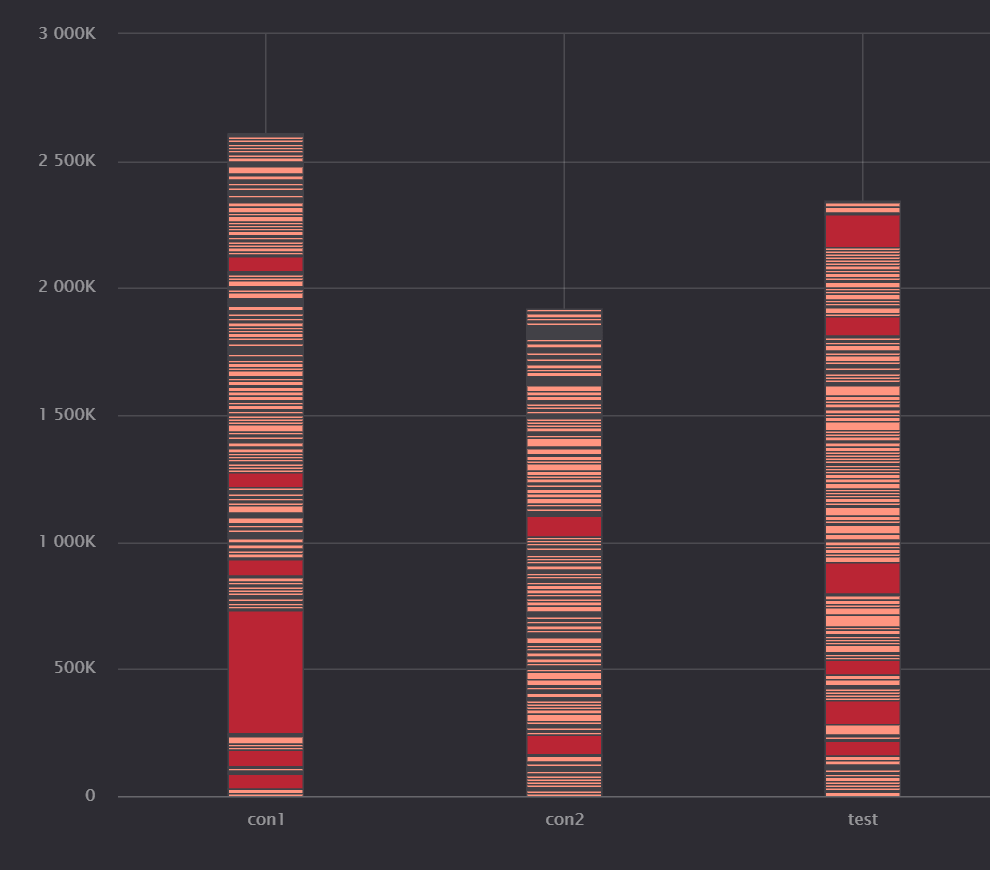
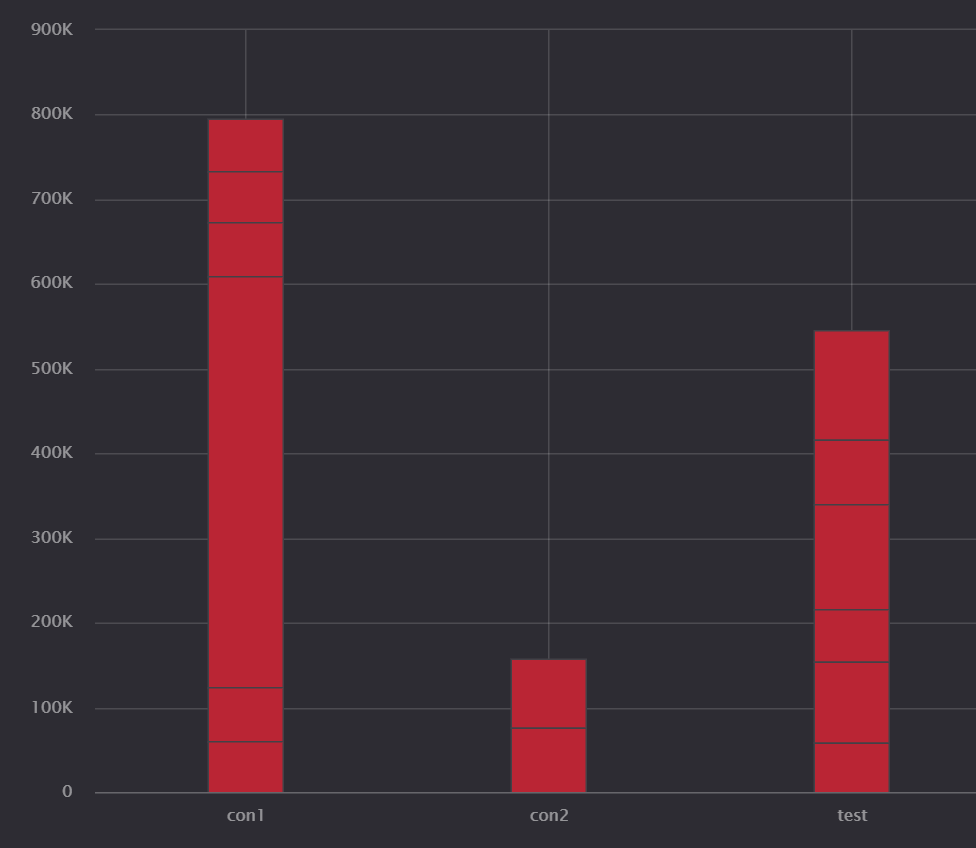

  Кстати, зачем колонки с id слева? Ну, просто дополнительно решил посмотреть id пользователей - да, всё замечательно, это разные люди, группы действительно состоят из разных людей :) (ну, для меня аналитик должен быть умеренным параноиком, так что решил на всякий случай и это проверить).

  Заметка №8 - кстати(2), можно заметить что суммарная выручка тестовой группы опять плавает между 1 и 2 группами. То есть прямого заметного профита эксперимент всё-таки не дал, поскольку киты есть и в тестовой, это частично компенсирует 400к-кита в 1 контрольной группе. 
   Тем не менее, давайте сузим подсчёты и перейдём сразу на интересующую нас зону - premium_no_trial.

In [15]:
premium_mobydicks = pd.DataFrame()
premium_mobydicks['prem_cg_1_id'] = trancon1.query('product_type == "premium_no_trial"').groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['uid'].head(10).values
premium_mobydicks['prem_cg_2_id'] = trancon2.query('product_type == "premium_no_trial"').groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['uid'].head(10).values
premium_mobydicks['prem_tg_id'] = trantest.query('product_type == "premium_no_trial"').groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['uid'].head(10).values
premium_mobydicks['prem_cg1_rev'] = trancon1.query('product_type == "premium_no_trial"').groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].head(10).values.astype(int)
premium_mobydicks['prem_cg_2_rev'] = trancon2.query('product_type == "premium_no_trial"').groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].head(10).values
premium_mobydicks['prem_tg_rev'] = trantest.query('product_type == "premium_no_trial"').groupby('uid',as_index=False).revenue.sum().sort_values('revenue', ascending=False)['revenue'].head(10).values
premium_mobydicks['prem_cg1_rev_sum'] = trancon1.query('product_type == "premium_no_trial"').revenue.sum().astype(int)
premium_mobydicks['prem_cg_2_rev_sum'] = trancon2.query('product_type == "premium_no_trial"').revenue.sum()
premium_mobydicks['prem_tg_rev_sum'] = trantest.query('product_type == "premium_no_trial"').revenue.sum()
premium_mobydicks['cg1_prem/full'] = trancon1.query('product_type == "premium_no_trial"').revenue.sum().astype(int) / trancon1.revenue.sum() 
premium_mobydicks['cg2_prem/full'] = trancon2.query('product_type == "premium_no_trial"').revenue.sum() / trancon2.revenue.sum() 
premium_mobydicks['tg_prem/full'] = trantest.query('product_type == "premium_no_trial"').revenue.sum() / trantest.revenue.sum()
premium_mobydicks

,prem_cg_1_id,prem_cg_2_id,prem_tg_id,prem_cg1_rev,prem_cg_2_rev,prem_tg_rev,prem_cg1_rev_sum,prem_cg_2_rev_sum,prem_tg_rev_sum,cg1_prem/full,cg2_prem/full,tg_prem/full
0,892333905,891778551,892038759,63037,81796,113477,779259,744809,810706,0.298303,0.387833,0.345731
1,892216461,892307238,891178380,63037,63037,113477,779259,744809,810706,0.298303,0.387833,0.345731
2,891383310,892139829,892097937,63037,15457,24531,779259,744809,810706,0.298303,0.387833,0.345731
3,892421277,891637005,892065108,47723,12688,21307,779259,744809,810706,0.298303,0.387833,0.345731
4,892101909,891307146,891725043,12844,10608,18434,779259,744809,810706,0.298303,0.387833,0.345731
5,892366260,891907050,892426491,12584,10413,12597,779259,744809,810706,0.298303,0.387833,0.345731
6,891216033,891136632,892050108,12584,10413,12597,779259,744809,810706,0.298303,0.387833,0.345731
7,892290105,891219540,892186941,10829,9438,12597,779259,744809,810706,0.298303,0.387833,0.345731
8,891822480,891436563,891861489,8190,9360,12597,779259,744809,810706,0.298303,0.387833,0.345731
9,892061721,891295332,891867477,7930,9100,12597,779259,744809,810706,0.298303,0.387833,0.345731


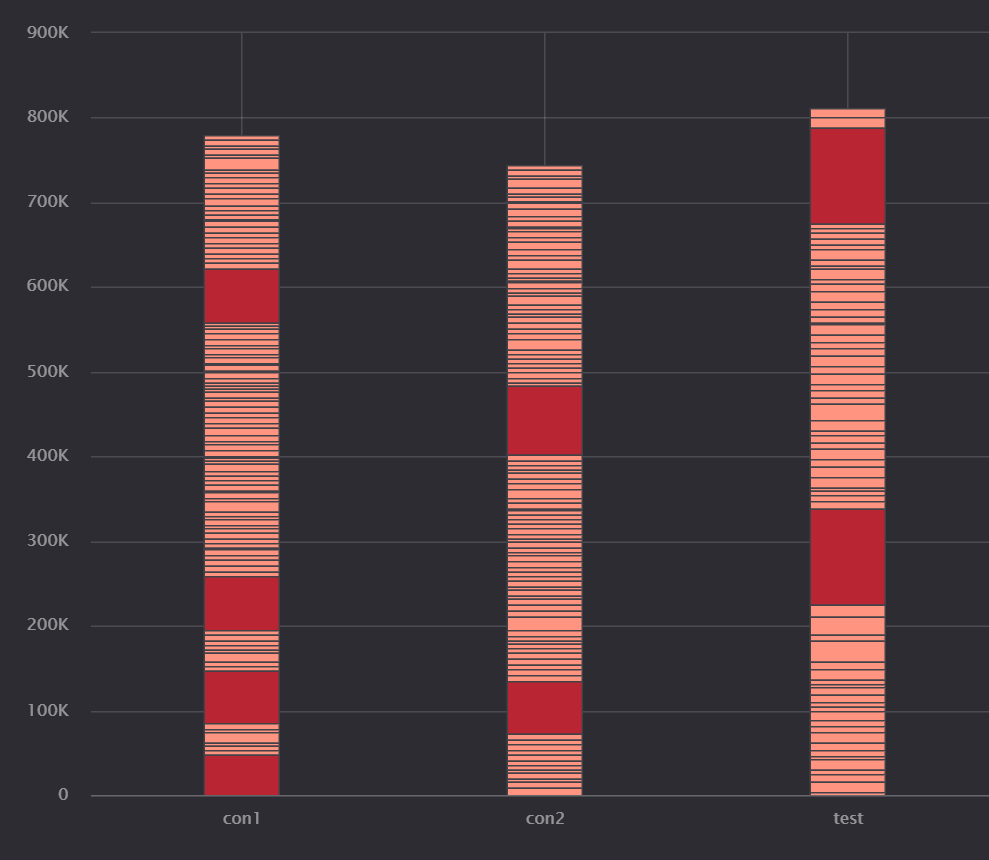
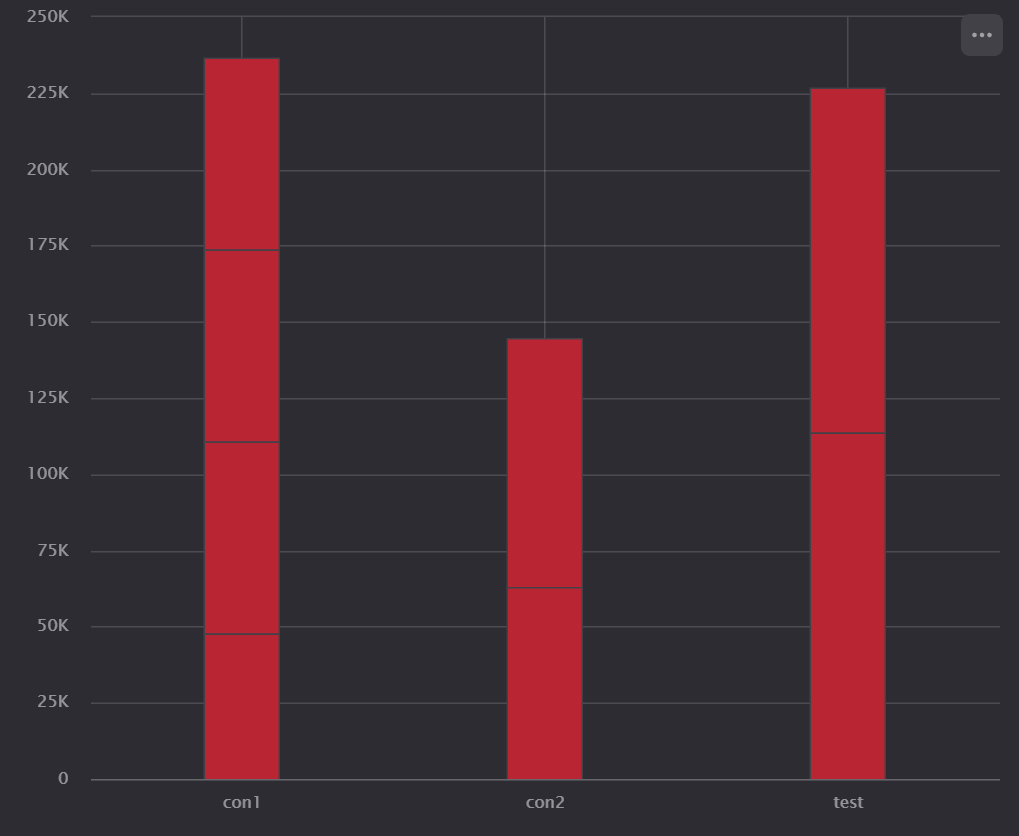
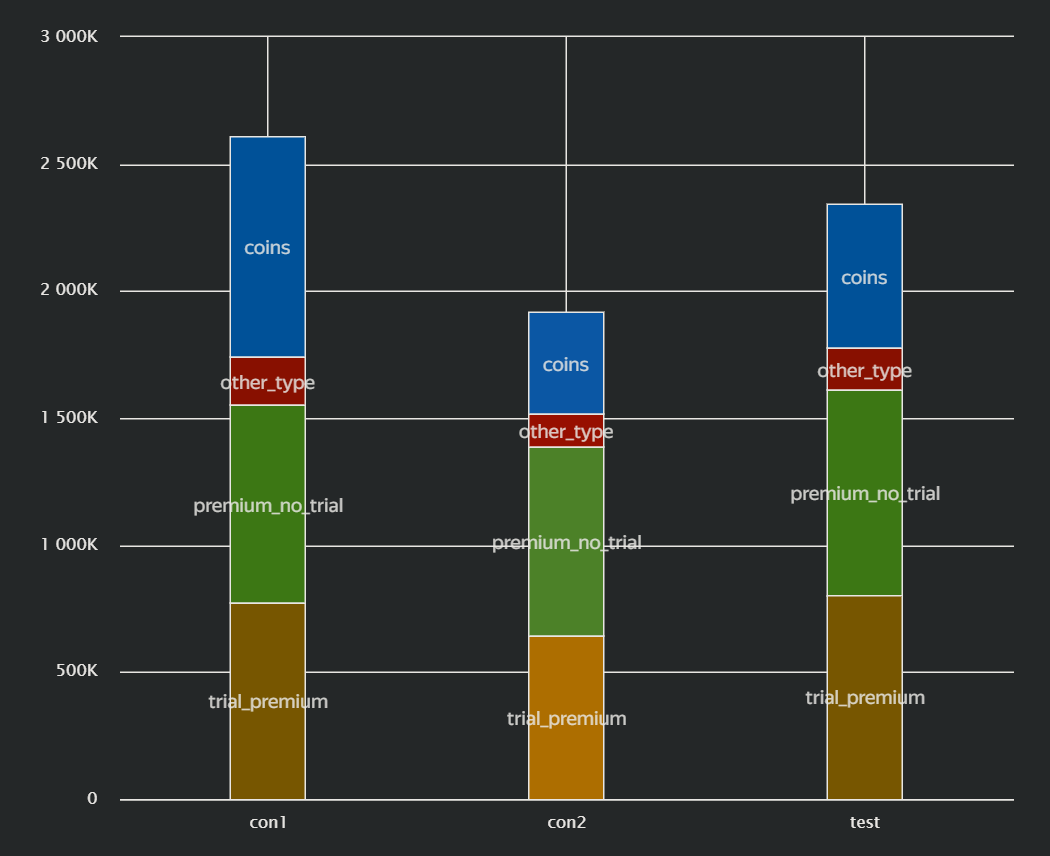

Заметка №9 - как можно заметить, доля выручки от премиум-подписок относительно общей выручки тестовой группы в очередной раз плавает между контрольными - 30%(con1), 39%(con2) и 35%(test).

Также видно, что тестовая группа незначительно убежала вперёд по самой выручке за премиум-подписки. В прочем, учитывая размеры китов, одной транзакцией вносящих дизбаланс, упор здесь явно на "незначительно".

Чтож, переходим к метрикам среднего чека. Думаю они - главное, что здесь стоило бы проверить.

Заметка №10 - считаем ARPPU и ARPU. Начнём пожалуй с ARPPU. 

In [16]:
print("Подсчёт через users:\n")
print(f"ARPPU 1 контрольной группы - {usercon1.loc[usercon1['total_revenue'] != 0].total_revenue.mean():.2f}")
print(f"ARPPU 2 контрольной группы - {usercon2.loc[usercon2['total_revenue'] != 0].total_revenue.mean():.2f}")
print(f"ARPPU тестовой группы - {usertest.loc[usertest['total_revenue'] != 0].total_revenue.mean():.2f}\n")
print("Подсчёт через transactions:\n")
print(f"ARPPU 1 контрольной группы - {trancon1.groupby('uid').revenue.sum().mean():.2f}")
print(f"ARPPU 2 контрольной группы - {trancon2.groupby('uid').revenue.sum().mean():.2f}")
print(f"ARPPU тестовой группы - {trantest.groupby('uid').revenue.sum().mean():.2f}")

Подсчёт через users:

ARPPU 1 контрольной группы - 13444.10
ARPPU 2 контрольной группы - 10269.72
ARPPU тестовой группы - 15759.03

Подсчёт через transactions:

ARPPU 1 контрольной группы - 13535.29
ARPPU 2 контрольной группы - 10269.72
ARPPU тестовой группы - 16060.97


Небольшая разница в просчётах - это (как я выяснил фоном, но решил не запихивать эти поиски, поскольку кода и так уже много) неполные суммы total_revenue в таблицах users. Возможно users грузили раньше чем transactions. Посему, правильные значения - при подсчёте через transactions.

А теперь перейдём конкретно к премиум-ARPPU и премиум-ATV (поскольку киты могут подкрутить результаты, хотя как мы уже выяснили, они плюс минус компенсируют друг друга, находясь во всех трёх группах). Посчитаю через среднее и через медиану.

In [17]:
print('Премиум - ARPPU (контрольная 1, контрольная 2, тестовая)\n')
print(round(trancon1.groupby(["uid","product_type"],as_index=False).revenue.sum().query("product_type == 'premium_no_trial'").revenue.mean()))
print(round(trancon2.groupby(["uid","product_type"],as_index=False).revenue.sum().query("product_type == 'premium_no_trial'").revenue.mean()))
print(round(trantest.groupby(["uid","product_type"],as_index=False).revenue.sum().query("product_type == 'premium_no_trial'").revenue.mean()))
print("\n")
print('Премиум - Average Transaction Value (контрольная 1, контрольная 2, тестовая)\n')
print(round(trancon1.query("product_type =='premium_no_trial'").revenue.mean()))
print(round(trancon2.query("product_type =='premium_no_trial'").revenue.mean()))
print(round(trantest.query("product_type =='premium_no_trial'").revenue.mean()))
print("\n")
print('Премиум - MRPPU (Median) (контрольная 1, контрольная 2, тестовая)\n')
print(trancon1.groupby(["uid","product_type"],as_index=False).revenue.sum().query("product_type == 'premium_no_trial'").revenue.median())
print(trancon2.groupby(["uid","product_type"],as_index=False).revenue.sum().query("product_type == 'premium_no_trial'").revenue.median())
print(trantest.groupby(["uid","product_type"],as_index=False).revenue.sum().query("product_type == 'premium_no_trial'").revenue.median())
print("\n")
print('Премиум - Median Transaction Value (контрольная 1, контрольная 2, тестовая)\n')
print(trancon1.query("product_type =='premium_no_trial'").revenue.median())
print(trancon2.query("product_type =='premium_no_trial'").revenue.median())
print(trantest.query("product_type =='premium_no_trial'").revenue.median())

Премиум - ARPPU (контрольная 1, контрольная 2, тестовая)

7871
7302
12100


Премиум - Average Transaction Value (контрольная 1, контрольная 2, тестовая)

7352
6961
10667


Премиум - MRPPU (Median) (контрольная 1, контрольная 2, тестовая)

6292.0
6292.0
8268.0


Премиум - Median Transaction Value (контрольная 1, контрольная 2, тестовая)

6292.0
6292.0
8021.0


Заметка №11 - однако же, что по медианному подсчёту, что по среднему, наблюдается действительно большой скачок среднего чека (среди платящих). Нет, я не забыл вот про этих 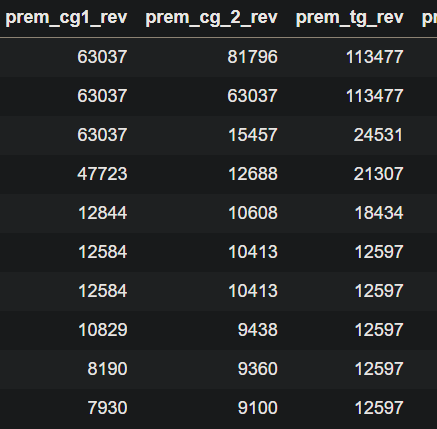

но медиана должна была загасить их всех равномерно. Так что это выглядит как умеренная победа и успешность эксперимента в отношении ARPPU.

А теперь переходим к ARPU. Вспоминаем про то что процент платящих в тестовой группе относительно контрольных  упал с 4.4% до 3.4% (в 1.3 раза (~190 чел в контрольных группах и ~145 в тестовой).

In [18]:
print(f"ARPU 1 контрольной группы - {usercon1.total_revenue.mean():.2f}")
print(f"ARPU 2 контрольной группы - {usercon2.total_revenue.mean():.2f}")
print(f"ARPU тестовой группы - {usertest.total_revenue.mean():.2f}")

ARPU 1 контрольной группы - 594.76
ARPU 2 контрольной группы - 450.38
ARPU тестовой группы - 534.08


Заметка №12 - кстати, пока шарился по датасету, заметил, что у нас есть пользователи, совершившие покупку до присоедения к сервису. С ними явно стоит разобраться

In [21]:
print(f'В 1 контрольной группе {trancon1.query("paid_at < joined_at").uid.nunique()} уникальных пользователей совершили {trancon1.query("paid_at < joined_at").uid.count()} транзакций до регистрации')
print(f'Во 2 контрольной группе {trancon2.query("paid_at < joined_at").uid.nunique()} уникальных пользователей совершили {trancon2.query("paid_at < joined_at").uid.count()} транзакций до регистрации')
print(f'В тестовой группе {trantest.query("paid_at < joined_at").uid.nunique()} уникальных пользователей совершили {trantest.query("paid_at < joined_at").uid.count()} транзакций до регистрации')

print(f'\nВсего в 1 контрольной группе было {trancon1.uid.nunique()} уникальных пользователей и {trancon1.uid.count()} транзакций')
print(f'Всего во 2 контрольной группе было {trancon2.uid.nunique()} уникальных пользователей и {trancon2.uid.count()} транзакций')
print(f'Всего в тестовой контрольной группе было {trantest.uid.nunique()} уникальных пользователей и {trantest.uid.count()} транзакций')

print(f'\nПроцентное соотношение по пользователям/транзакциям:\n\n{37/193*100:.2f}%/{55/377*100:.2f}% в 1 группе, {41/187*100:.2f}%/{60/328*100:.2f}% во 2 и {35/146*100:.2f}%/{47/273*100:.2f}% в тестовой')

В 1 контрольной группе 37 уникальных пользователей совершили 55 транзакций до регистрации
Во 2 контрольной группе 41 уникальных пользователей совершили 60 транзакций до регистрации
В тестовой группе 35 уникальных пользователей совершили 47 транзакций до регистрации

Всего в 1 контрольной группе было 193 уникальных пользователей и 377 транзакций
Всего во 2 контрольной группе было 187 уникальных пользователей и 328 транзакций
Всего в тестовой контрольной группе было 146 уникальных пользователей и 273 транзакций

Процентное соотношение по пользователям/транзакциям:

19.17%/14.59% в 1 группе, 21.93%/18.29% во 2 и 23.97%/17.22% в тестовой


Окей, доля небольшая, но достаточно ощутимая. Видимо их надо просто вырезать из общей статистики? Но окей, поглядим на них конкретнее.

In [22]:
trantest.query("paid_at < joined_at").sort_values(["product_type","uid","paid_at"])


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
200,891589239,Italy,2017-10-31 14:16:00,2017-02-11 11:45:00,6305,19,autorefill,coins
177,891589239,Italy,2017-10-31 14:16:00,2017-04-11 06:46:00,6305,19,autorefill,coins
36,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins
100,891600819,United States of America,2017-10-31 08:41:00,2017-05-11 19:10:00,4602,146,empty_likes,coins
245,891861048,Canada,2017-10-26 02:55:00,2017-01-11 07:13:00,3523,19,none,coins
184,891861594,Chile,2017-10-26 02:25:00,2017-01-11 04:37:00,4004,19,empty_likes,coins
118,891861594,Chile,2017-10-26 02:25:00,2017-09-11 23:32:00,4030,19,empty_likes,coins
217,891882681,Belgium,2017-10-25 17:25:00,2017-04-11 10:26:00,7813,146,empty_likes,coins
161,891986289,France,2017-10-23 13:08:00,2017-08-11 13:22:00,12610,19,autorefill,coins
260,892018248,United Kingdom (Great Britain),2017-10-22 19:50:00,2017-01-11 13:42:00,6032,19,likes,coins


Welllll... тяжело... Везде в платёжках стоит 11 число любого месяца, что сначала навело меня на мысль, что это ежемесячная оплата премиума, но как видно - нет (в других группах если что всё также), часть транзакций - монеты, а премиумы слишком разбиты по разным пользователям, чтобы увидеть какую-либо систематичность (ну скажем, какой-то из пользователей каким-то нелепым образом подписал и не отменил себе премиум, а регистрацию не оформил, или какой-нибудь ещё сюр).

In [23]:
trantest.query("paid_at < joined_at").sort_values(["joined_at","uid"])

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
128,892339626,United States of America,2017-10-15 23:21:00,2017-05-11 00:19:00,1872,19,none,coins
64,892275462,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083,19,coins_popup,other_type
56,892261437,Italy,2017-10-17 14:22:00,2017-06-11 11:51:00,1898,68,none,premium_no_trial
231,892225122,Spain,2017-10-18 10:11:00,2017-03-11 14:53:00,3094,19,empty_likes,coins
74,892205850,Spain,2017-10-18 19:20:00,2017-02-11 00:13:00,5408,147,promo_09,premium_no_trial
38,892065108,France,2017-10-21 20:40:00,2017-08-11 22:45:00,7098,147,popular_users_chat,premium_no_trial
71,892065108,France,2017-10-21 20:40:00,2017-10-11 15:27:00,871,19,menu,coins
114,892065108,France,2017-10-21 20:40:00,2017-10-11 15:26:00,871,146,menu,coins
175,892065108,France,2017-10-21 20:40:00,2017-10-11 15:27:00,3913,19,menu,coins
185,892065108,France,2017-10-21 20:40:00,2017-09-11 10:45:00,7098,147,popular_users_chat,premium_no_trial


Также можно заметить, что даты регистрации охватывают довольно узкий период (2 недели с 15 по 31 октября). Во всех 3 группах. Что означает, что...

Теория №1 - каждое 11 число неприкаянные души вселялись в интернет и сидели в дейтинг-приложении, пугая несмышлёных девочек (я прочекал (pd.merge(usertest,trantest.query("paid_at < joined_at").sort_values(["joined_at","uid"]),on="uid",how="inner")) - одни мужики) но ближе к наступлению Хэллоуина всемирная языческая полиция связалась с разработчиками, так что хитрым эфирным существам пришлось, дабы не спалить свою незаконную эмиграцию в реальный мир, официально зарегистрироваться, притворившись реальными людьми. 

Теория №2 - ну а если шутки в сторону, то возможно просто отгрузка данных из какой-то другой системы, честно, не знаю, первая теория мне явно больше нравится. Проблема в том, что какого-то существенного итога, кроме как забраковать эти транзакции из подсчётов метрик, я, хоть убейте, не вижу вообще. 

Ну, ладно, пересчёт оформлю чуть позже, пока посмотрю другие пункты.

Заметка №13 - безуспешно повоевал с расшифровкой пользы от колонки payment_id, систематики для анализа она не добавила, но вот небольшая сводка что я смог обнаружить в смысловом плане.

In [24]:
trancon1['payment_id'] = trancon1['payment_id'].astype(int)
trancon1.groupby('payment_id',as_index=False).product_type.value_counts().sort_values(['payment_id','count'])
#trancon2.groupby('payment_id',as_index=False).product_type.value_counts().sort_values(['payment_id','count'])
#trantest.groupby('payment_id',as_index=False).product_type.value_counts().sort_values(['payment_id','count'])

,payment_id,product_type,count
1,0,premium_no_trial,2
0,0,other_type,3
3,19,other_type,4
2,19,coins,117
4,67,other_type,41
6,68,other_type,2
5,68,premium_no_trial,16
7,127,other_type,5
8,146,coins,32
10,147,trial_premium,67


0 - premium_no_trial (плюс некоторые рефанды (если это означает refund_VP из from_page), так что возможно это... не знаю, неудачные или отменённые или завершающие премиумы?)

19 - coins (с разных страниц, видимо просто пополнение баланса для последующих донаций, i guess)

67 - other_type (оплата каких-то айтемов? да что угодно в целом, сильно много конкретики о внутренней кухне доната не имею, увы)

68 - premium_no_trial (подавляющим образом, ещё есть странные super_popup с немалым revenue, не осмелюсь сказать что это, суперлайк, суперсвайп или что там ещё бывает, в тиндере к сожалению сто лет уже не сидел. Но ценник меня смущает, даже не знаю что это за финансовые перверсии от китов)

146 - coins (не нашёл отличий от 19, вот прямо совсем)

147 - trial_premium / premium_no_trial (видимо всё что касается них, но как сюда вписывается "0" я так и не понял. Вряд ли это неудачные транзакции, поскольку... 

In [25]:
trantest.query('uid == 891725043')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
152,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,147,none,premium_no_trial
220,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,0,none,premium_no_trial


In [26]:
usertest.query('uid == 891725043')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
2935,891725043,28,282,NaN,United Arab Emirates,"1,2,3,4,5,6,8,9,10,12,13,15,16,17",1,25,31,117,1.0,1.0,18434


...вот у этого арабского (не)шейха (довольно активного по дням), например, total_revenue засчитал обе оплаты премиума. По дате они синхронные до секунд, оба с none-страницы, и всё намекает на то что это просто прошедшая только со второго раза оплата, но... 

Не, если конечно уходить в паранойю, возможно у нас вообще в корне неверное total_revenue, считающее неудачные транзакции за удачные. Но я на такие теории заговора пока не хочу замахиваться. 

Итог по payment_id - я правда не знаю что они мне базово дадут в этом случае. Если я до чего-то тут всё-таки не докопался - прошу прощения, вообще ноль идей.

Лады. Довольно нелинейную, но сводку данных я обозначил, можно переходить к главной практической части - 
# СТАТТЕСТЫ

Для начала: для пола будем использовать хи-квадрат, для возраста - t-тест (что логично, учитывая что пол у нас категориальная величина)

In [27]:
# сшиваем таблицы в одну и помечаем по группам
all_users = pd.concat([
                        usercon1.assign(group='con1'),  
                        usercon2.assign(group='con2'),  
                        usertest.assign(group='test')])
contingency_table = pd.crosstab(all_users['group'], all_users['gender'])
print("\nТаблица сопряжённости (группа × пол):")
print(contingency_table)

# проводим хи-квадрат тест
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nХи-квадрат тест для пола:")
print(f"  p-value = {p_value:.4f}")
print(f"  Вывод: {'Группы похожи по полу (p > 0.05)' if p_value > 0.05 else 'Группы РАЗЛИЧАЮТСЯ по полу (p < 0.05)!'}")


Таблица сопряжённости (группа × пол):
gender    0     1
group            
con1    182  4158
con2    195  4069
test    202  4106

Хи-квадрат тест для пола:
  p-value = 0.5075
  Вывод: Группы похожи по полу (p > 0.05)


Чтож, p-value мы не перескочили. Кстати, если мне не изменяет память, в лекции по категориальным переменным мы вроде бы вообще брали 99%-ный интервал. Его бы мы тут и близко не перескочили. Следовательно - ГРУППЫ ИДЕНТИЧНЫ!

UPD: Вообще, погуглив чуть больше, возможно надо было сравнить группы как и в t-тесте - каждую с каждой. Но в таком случае тоже ничего не меняется. 

In [28]:
import itertools
pairs = [('test', 'con1'), ('test', 'con2'), ('con1', 'con2')]
print("Попарный хи-квадрат для пола:")
for group1, group2 in pairs:
    subset = all_users[all_users['group'].isin([group1, group2])]
    table = pd.crosstab(subset['group'], subset['gender'])
    chi2, p, dof, exp = chi2_contingency(table)
    print(f"  {group1} vs {group2}: p-value = {p:.4f} {'(похожи)' if p > 0.05 else '(РАЗЛИЧАЮТСЯ!)'}")

Попарный хи-квадрат для пола:
  test vs con1: p-value = 0.2864 (похожи)
  test vs con2: p-value = 0.8386 (похожи)
  con1 vs con2: p-value = 0.4194 (похожи)


А теперь возраст.

In [29]:
# для протокола перепроверю NaN
print(f"\nПропуски возраста:")
print(f"  con1: {usercon1['age'].isna().sum()}")
print(f"  con2: {usercon2['age'].isna().sum()}")
print(f"  test: {usertest['age'].isna().sum()}")

# Проводим t-тест 

age_test = usertest['age'].dropna()
age_con1 = usercon1['age'].dropna()
age_con2 = usercon2['age'].dropna()
t_stat1, p_value1 = ttest_ind(age_test, age_con1)
t_stat2, p_value2 = ttest_ind(age_test, age_con2)
t_stat3, p_value3 = ttest_ind(age_con1, age_con2)
print(f"\nt-тест для возраста:")
print(f"  test vs con1: p-value = {p_value1:.4f} {'(похожи)' if p_value1 > 0.05 else '(РАЗЛИЧАЮТСЯ!)'}")
print(f"  test vs con2: p-value = {p_value2:.4f} {'(похожи)' if p_value2 > 0.05 else '(РАЗЛИЧАЮТСЯ!)'}")
print(f"  con1 vs con2: p-value = {p_value3:.4f} {'(похожи)' if p_value3 > 0.05 else '(РАЗЛИЧАЮТСЯ!)'}")


Пропуски возраста:
  con1: 0
  con2: 0
  test: 0

t-тест для возраста:
  test vs con1: p-value = 0.3499 (похожи)
  test vs con2: p-value = 0.4767 (похожи)
  con1 vs con2: p-value = 0.8233 (похожи)


Ну а тут всё совсем гладко. ГРУППЫ ИДЕНТИЧНЫ!

Ну и в качестве третьей метрики я возьму коэффициент привлекательности. 

In [30]:
t1, p1 = ttest_ind(usertest['attraction_coeff'].dropna(), usercon1['attraction_coeff'].dropna())
print(f"Test vs Con1: p = {p1:.4f} {'✅ похожи' if p1 > 0.05 else '⚠️ различаются'}")

t2, p2 = ttest_ind(usertest['attraction_coeff'].dropna(), usercon2['attraction_coeff'].dropna())
print(f"Test vs Con2: p = {p2:.4f} {'✅ похожи' if p2 > 0.05 else '⚠️ различаются'}")

t3, p3 = ttest_ind(usercon1['attraction_coeff'].dropna(), usercon2['attraction_coeff'].dropna())
print(f"Con1 vs Con2: p = {p3:.4f} {'✅ похожи' if p3 > 0.05 else '⚠️ различаются'}")

Test vs Con1: p = 0.5290 ✅ похожи
Test vs Con2: p = 0.8256 ✅ похожи
Con1 vs Con2: p = 0.3971 ✅ похожи


Что в целом можно было бы увидеть, если просто посчитать банальные средние или медианы.

In [31]:
# Средние по attraction_coeff
print("Средние:")
print(f"Test: {usertest['attraction_coeff'].mean():.2f}")
print(f"Con1: {usercon1['attraction_coeff'].mean():.2f}")
print(f"Con2: {usercon2['attraction_coeff'].mean():.2f}")

# Медианы по attraction_coeff
print("\nМедианы:")
print(f"Test: {usertest['attraction_coeff'].median():.2f}")
print(f"Con1: {usercon1['attraction_coeff'].median():.2f}")
print(f"Con2: {usercon2['attraction_coeff'].median():.2f}")

Средние:
Test: 316.41
Con1: 312.05
Con2: 317.96

Медианы:
Test: 250.00
Con1: 238.50
Con2: 250.00


Итого, демографически группы идентичны по 3 параметрам (пол, возраст, коэффициент привлекательности). А, и кстати, можно ещё отсечь по общим странам. Сделаю это буквально на следующем шагу.

А теперь посмотрим на ARPU, ARPPU, CR и потом на влияние китов на эти метрики. Тут вероятно, лучше подойдёт bootstrap, чем t-тест, потому что неравномерность данных, всё те же пресловутые киты и бла-бла-бла.
Но для начала, выведу общие страны

In [32]:
topcountries_con1 = usercon1.country.value_counts(normalize=True).head(15).reset_index()
topcountries_con2 = usercon2.country.value_counts(normalize=True).head(15).reset_index()
topcountries_test = usertest.country.value_counts(normalize=True).head(15).reset_index()
topcoun12 = pd.merge(topcountries_con1,topcountries_con2,on="index",how="inner")
topcoun12t = pd.merge(topcoun12,topcountries_test,on='index',how='inner')
topcoun12t.rename(columns={'index': 'country', 
                   'country_x': 'con1',
                   'country_y': 'con2', 
                   'country': 'test'}, inplace=True)
print(round(topcoun12t,2))
print(f"\nПользователи из этих 15 общих стран составляют {usercon1.country.value_counts(normalize=True).head(15).sum()*100:.2f} % от всех пользователей в 1 контрольной группе")
print(f"\nПользователи из этих 15 общих стран составляют {usercon2.country.value_counts(normalize=True).head(15).sum()*100:.2f} % от всех пользователей во 2 контрольной группе")
print(f"\nПользователи из этих 15 общих стран составляют {usertest.country.value_counts(normalize=True).head(15).sum()*100:.2f} % от всех пользователей в тестовой группе")

                           country  con1  con2  test
0         United States of America  0.34  0.35  0.34
1                        Argentina  0.09  0.09  0.09
2                           France  0.09  0.09  0.08
3                            Spain  0.08  0.07  0.07
4                            Italy  0.08  0.07  0.07
5                            Chile  0.07  0.07  0.06
6             United Arab Emirates  0.05  0.05  0.05
7                          Germany  0.04  0.05  0.05
8   United Kingdom (Great Britain)  0.03  0.03  0.04
9                           Canada  0.03  0.03  0.03
10                          Israel  0.03  0.02  0.02
11                         Belgium  0.02  0.02  0.02
12                        Portugal  0.02  0.02  0.02
13                       Australia  0.01  0.01  0.01
14                     Switzerland  0.01  0.01  0.01

Пользователи из этих 15 общих стран составляют 98.64 % от всех пользователей в 1 контрольной группе

Пользователи из этих 15 общих стран составляют 98.

Что ж, отфлильтровали и по людям почти ничего не потеряли.

И вот наконец проводим статтесты (сразу по premium_no_trial, поскольку нам интересны только они)

In [5]:
from scipy.stats import bootstrap, ttest_ind
import numpy as np

# ==============================================================================
# ПОЯСНЕНИЕ ДЛЯ РЕВЬЮЕРА:
# 
# В предыдущей версии я пытался вычислить p-value через бутстрап для двух групп.
# Это была ошибка не в коде, а в логике: бутстрап не моделирует нулевую гипотезу (H₀).
# 
# Бутстрап спрашивает: «Насколько устойчива наблюдаемая разница?»
# Перестановочный тест спрашивает: «Могла ли такая разница возникнуть, если бы различия не существовало?»
# 
# Первое — оценка. Второе — проверка.
# 
# Теперь:
#   • t-тест — параметрическая проверка (быстро, но с допущениями),
#   • перестановочный тест — непараметрическая проверка H₀ (точно, без допущений),
#   • бутстрап — ТОЛЬКО для доверительных интервалов (оценка эффекта).
# 
# Ошибку я осознал: нельзя заставить бутстрап отвечать на вопрос, для которого он не предназначен.
# ==============================================================================

# ========== 1. БАЗОВЫЕ ПОДГОТОВКИ ==========
print("="*70)
print("ПОДГОТОВКА ДАННЫХ")
print("="*70)

# 1.1 Только топ-15 стран
all_countries = pd.concat([usercon1['country'], usercon2['country'], usertest['country']])
top_countries = all_countries.value_counts().head(15).index

usertest_top = usertest[usertest['country'].isin(top_countries)]
usercon1_top = usercon1[usercon1['country'].isin(top_countries)]
usercon2_top = usercon2[usercon2['country'].isin(top_countries)]

print(f"Пользователей после фильтрации стран:")
print(f"  Test: {len(usertest_top)} из {len(usertest)}")
print(f"  Con1: {len(usercon1_top)} из {len(usercon1)}")
print(f"  Con2: {len(usercon2_top)} из {len(usercon2)}")

# 1.2 Только premium_no_trial
trantest_premium = trantest[trantest['product_type'] == 'premium_no_trial']
trancon1_premium = trancon1[trancon1['product_type'] == 'premium_no_trial']
trancon2_premium = trancon2[trancon2['product_type'] == 'premium_no_trial']

# 1.3 Без аномалий (paid_at >= joined_at)
trantest_clean = trantest_premium[trantest_premium['paid_at'] >= trantest_premium['joined_at']]
trancon1_clean = trancon1_premium[trancon1_premium['paid_at'] >= trancon1_premium['joined_at']]
trancon2_clean = trancon2_premium[trancon2_premium['paid_at'] >= trancon2_premium['joined_at']]

print(f"\nPremium_no_trial транзакций:")
print(f"  Test: {len(trantest_clean)} чистых из {len(trantest_premium)} всего")
print(f"  Con1: {len(trancon1_clean)} чистых из {len(trancon1_premium)} всего")
print(f"  Con2: {len(trancon2_clean)} чистых из {len(trancon2_premium)} всего")

# ========== 2. ПОДГОТОВКА МЕТРИК ==========
print("\n" + "="*70)
print("РАСЧЕТ МЕТРИК")
print("="*70)

# 2.1 ARPU (из total_revenue всех пользователей)
arpu_test = usertest_top['total_revenue'].fillna(0).values
arpu_con1 = usercon1_top['total_revenue'].fillna(0).values
arpu_con2 = usercon2_top['total_revenue'].fillna(0).values

print(f"\nARPU (все пользователи):")
print(f"  Test: {np.mean(arpu_test):.2f} (n={len(arpu_test)})")
print(f"  Con1: {np.mean(arpu_con1):.2f} (n={len(arpu_con1)})")
print(f"  Con2: {np.mean(arpu_con2):.2f} (n={len(arpu_con2)})")

# 2.2 ARPPU (только premium_no_trial пользователи)
arppu_test = trantest_clean.groupby('uid')['revenue'].sum().values
arppu_con1 = trancon1_clean.groupby('uid')['revenue'].sum().values
arppu_con2 = trancon2_clean.groupby('uid')['revenue'].sum().values

print(f"\nARPPU (premium_no_trial пользователи):")
print(f"  Test: {np.mean(arppu_test):.2f} (n={len(arppu_test)})")
print(f"  Con1: {np.mean(arppu_con1):.2f} (n={len(arppu_con1)})")
print(f"  Con2: {np.mean(arppu_con2):.2f} (n={len(arppu_con2)})")

# 2.3 CR (конверсия в premium_no_trial)
premium_uids_test = trantest_clean['uid'].unique()
premium_uids_con1 = trancon1_clean['uid'].unique()
premium_uids_con2 = trancon2_clean['uid'].unique()

cr_test = usertest_top['uid'].isin(premium_uids_test).astype(int).values
cr_con1 = usercon1_top['uid'].isin(premium_uids_con1).astype(int).values
cr_con2 = usercon2_top['uid'].isin(premium_uids_con2).astype(int).values

print(f"\nCR (конверсия в premium_no_trial):")
print(f"  Test: {np.mean(cr_test):.4f} ({len(premium_uids_test)}/{len(usertest_top)})")
print(f"  Con1: {np.mean(cr_con1):.4f} ({len(premium_uids_con1)}/{len(usercon1_top)})")
print(f"  Con2: {np.mean(cr_con2):.4f} ({len(premium_uids_con2)}/{len(usercon2_top)})")

# ========== 3. ФУНКЦИИ ДЛЯ ТЕСТОВ ==========
def permutation_test(arr1, arr2, n_resamples=5000, random_state=42):
    """Корректный непараметрический p-value при H₀: разницы нет."""
    np.random.seed(random_state)
    observed_diff = np.mean(arr1) - np.mean(arr2)
    pooled = np.concatenate([arr1, arr2])
    diffs = []
    for _ in range(n_resamples):
        np.random.shuffle(pooled)
        new_arr1 = pooled[:len(arr1)]
        new_arr2 = pooled[len(arr1):]
        diffs.append(np.mean(new_arr1) - np.mean(new_arr2))
    p_val = (np.abs(diffs) >= np.abs(observed_diff)).mean()
    return observed_diff, p_val

def bootstrap_ci_only(arr1, arr2, n_resamples=5000, random_state=42):
    """Только доверительный интервал. НЕ p-value!"""
    result = bootstrap(
        (arr1, arr2),
        lambda x, y: np.mean(x) - np.mean(y),
        n_resamples=n_resamples,
        random_state=random_state
    )
    diff = np.mean(arr1) - np.mean(arr2)
    return diff, result.confidence_interval

# ========== 4. Т-ТЕСТЫ ==========
print("\n" + "="*70)
print("Т-ТЕСТЫ (параметрические)")
print("="*70)

# ARPU
_, p_arpu1_t = ttest_ind(arpu_test, arpu_con1, equal_var=False)
_, p_arpu2_t = ttest_ind(arpu_test, arpu_con2, equal_var=False)

# ARPPU
_, p_arppu1_t = ttest_ind(arppu_test, arppu_con1, equal_var=False)
_, p_arppu2_t = ttest_ind(arppu_test, arppu_con2, equal_var=False)

# CR
_, p_cr1_t = ttest_ind(cr_test, cr_con1, equal_var=False)
_, p_cr2_t = ttest_ind(cr_test, cr_con2, equal_var=False)

print(f"\nARPU t-тесты:")
print(f"  Test vs Con1: p = {p_arpu1_t:.4f} {'✅' if p_arpu1_t < 0.05 else '❌'}")
print(f"  Test vs Con2: p = {p_arpu2_t:.4f} {'✅' if p_arpu2_t < 0.05 else '❌'}")

print(f"\nARPPU t-тесты:")
print(f"  Test vs Con1: p = {p_arppu1_t:.4f} {'✅' if p_arppu1_t < 0.05 else '❌'}")
print(f"  Test vs Con2: p = {p_arppu2_t:.4f} {'✅' if p_arppu2_t < 0.05 else '❌'}")

print(f"\nCR t-тесты:")
print(f"  Test vs Con1: p = {p_cr1_t:.4f} {'✅' if p_cr1_t < 0.05 else '❌'}")
print(f"  Test vs Con2: p = {p_cr2_t:.4f} {'✅' if p_cr2_t < 0.05 else '❌'}")

# ========== 5. ПЕРЕСТАНОВОЧНЫЙ ТЕСТ (корректный p-value) ==========
print("\n" + "="*70)
print("ПЕРЕСТАНОВОЧНЫЙ ТЕСТ (непараметрический, моделирует H₀)")
print("="*70)

# ARPU
diff_arpu1_perm, p_arpu1_perm = permutation_test(arpu_test, arpu_con1)
diff_arpu2_perm, p_arpu2_perm = permutation_test(arpu_test, arpu_con2)

# ARPPU
diff_arppu1_perm, p_arppu1_perm = permutation_test(arppu_test, arppu_con1)
diff_arppu2_perm, p_arppu2_perm = permutation_test(arppu_test, arppu_con2)

# CR
diff_cr1_perm, p_cr1_perm = permutation_test(cr_test, cr_con1)
diff_cr2_perm, p_cr2_perm = permutation_test(cr_test, cr_con2)

print(f"\nARPU перестановочный тест:")
print(f"  Test vs Con1: p = {p_arpu1_perm:.4f} {'✅' if p_arpu1_perm < 0.05 else '❌'}")
print(f"  Test vs Con2: p = {p_arpu2_perm:.4f} {'✅' if p_arpu2_perm < 0.05 else '❌'}")

print(f"\nARPPU перестановочный тест:")
print(f"  Test vs Con1: p = {p_arppu1_perm:.4f} {'✅' if p_arppu1_perm < 0.05 else '❌'}")
print(f"  Test vs Con2: p = {p_arppu2_perm:.4f} {'✅' if p_arppu2_perm < 0.05 else '❌'}")

print(f"\nCR перестановочный тест:")
print(f"  Test vs Con1: p = {p_cr1_perm:.4f} {'✅' if p_cr1_perm < 0.05 else '❌'}")
print(f"  Test vs Con2: p = {p_cr2_perm:.4f} {'✅' if p_cr2_perm < 0.05 else '❌'}")

# ========== 6. БУТСТРАП (ТОЛЬКО ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ!) ==========
print("\n" + "="*70)
print("БУТСТРАП (оценка эффекта — НЕ p-value!)")
print("="*70)

# ARPU
diff_arpu1_b, ci_arpu1 = bootstrap_ci_only(arpu_test, arpu_con1)
diff_arpu2_b, ci_arpu2 = bootstrap_ci_only(arpu_test, arpu_con2)

# ARPPU
diff_arppu1_b, ci_arppu1 = bootstrap_ci_only(arppu_test, arppu_con1)
diff_arppu2_b, ci_arppu2 = bootstrap_ci_only(arppu_test, arppu_con2)

# CR
diff_cr1_b, ci_cr1 = bootstrap_ci_only(cr_test, cr_con1)
diff_cr2_b, ci_cr2 = bootstrap_ci_only(cr_test, cr_con2)

def ci_significant(ci):
    return not (ci.low <= 0 <= ci.high)

print(f"\nARPU бутстрап (95% CI):")
print(f"  Test vs Con1: [{ci_arpu1.low:.2f}, {ci_arpu1.high:.2f}] {'✅' if ci_significant(ci_arpu1) else '❌'}")
print(f"  Test vs Con2: [{ci_arpu2.low:.2f}, {ci_arpu2.high:.2f}] {'✅' if ci_significant(ci_arpu2) else '❌'}")

print(f"\nARPPU бутстрап (95% CI):")
print(f"  Test vs Con1: [{ci_arppu1.low:.2f}, {ci_arppu1.high:.2f}] {'✅' if ci_significant(ci_arppu1) else '❌'}")
print(f"  Test vs Con2: [{ci_arppu2.low:.2f}, {ci_arppu2.high:.2f}] {'✅' if ci_significant(ci_arppu2) else '❌'}")

print(f"\nCR бутстрап (95% CI):")
print(f"  Test vs Con1: [{ci_cr1.low:.4f}, {ci_cr1.high:.4f}] {'✅' if ci_significant(ci_cr1) else '❌'}")
print(f"  Test vs Con2: [{ci_cr2.low:.4f}, {ci_cr2.high:.4f}] {'✅' if ci_significant(ci_cr2) else '❌'}")

# ========== 7. АНАЛИЗ АНОМАЛИЙ ==========
print("\n" + "="*70)
print("АНАЛИЗ АНОМАЛИЙ (paid_at < joined_at)")
print("="*70)

arppu_test_anom = trantest_premium.groupby('uid')['revenue'].sum().values
arppu_con1_anom = trancon1_premium.groupby('uid')['revenue'].sum().values
arppu_con2_anom = trancon2_premium.groupby('uid')['revenue'].sum().values

# Только CI — без p-value!
diff_arppu1_anom, ci_arppu1_anom = bootstrap_ci_only(arppu_test_anom, arppu_con1_anom)
diff_arppu2_anom, ci_arppu2_anom = bootstrap_ci_only(arppu_test_anom, arppu_con2_anom)

print(f"\nARPPU с аномалиями:")
print(f"  Test: {np.mean(arppu_test_anom):.2f} (n={len(arppu_test_anom)})")
print(f"  Con1: {np.mean(arppu_con1_anom):.2f} (n={len(arppu_con1_anom)})")
print(f"  Test vs Con1 CI: [{ci_arppu1_anom.low:.2f}, {ci_arppu1_anom.high:.2f}]")
print(f"  Test vs Con2 CI: [{ci_arppu2_anom.low:.2f}, {ci_arppu2_anom.high:.2f}]")

print(f"\nВлияние аномалий на ARPPU:")
print(f"  +{len(arppu_test_anom)-len(arppu_test)} пользователей в тесте")
print(f"  +{len(arppu_con1_anom)-len(arppu_con1)} пользователей в Con1")

# ========== 8. АНАЛИЗ КИТОВ ==========
print("\n" + "="*70)
print("АНАЛИЗ КИТОВ (топ-10 по total_revenue)")
print("="*70)

whales_test = usertest_top.nlargest(10, 'total_revenue')['uid'].tolist()
whales_con1 = usercon1_top.nlargest(10, 'total_revenue')['uid'].tolist()
whales_con2 = usercon2_top.nlargest(10, 'total_revenue')['uid'].tolist()

arpu_test_no_whales = usertest_top[~usertest_top['uid'].isin(whales_test)]['total_revenue'].fillna(0).values
arpu_con1_no_whales = usercon1_top[~usercon1_top['uid'].isin(whales_con1)]['total_revenue'].fillna(0).values
arpu_con2_no_whales = usercon2_top[~usercon2_top['uid'].isin(whales_con2)]['total_revenue'].fillna(0).values

diff_arpu1_whale, ci_arpu1_whale = bootstrap_ci_only(arpu_test_no_whales, arpu_con1_no_whales)
diff_arpu2_whale, ci_arpu2_whale = bootstrap_ci_only(arpu_test_no_whales, arpu_con2_no_whales)

print(f"\nARPU без китов:")
print(f"  Test: {np.mean(arpu_test_no_whales):.2f} (n={len(arpu_test_no_whales)})")
print(f"  Con1: {np.mean(arpu_con1_no_whales):.2f} (n={len(arpu_con1_no_whales)})")
print(f"  Test vs Con1 CI: [{ci_arpu1_whale.low:.2f}, {ci_arpu1_whale.high:.2f}] {'✅' if ci_significant(ci_arpu1_whale) else '❌'}")

# ========== 9. ИТОГОВЫЕ ВЫВОДЫ ==========
print("\n" + "="*70)
print("ИТОГОВЫЕ ВЫВОДЫ")
print("="*70)

# Проверка значимости по каждой метрике
def is_significant_perm(p1, p2):
    return (p1 < 0.05) or (p2 < 0.05)

def is_significant_ci(ci1, ci2):
    return (not (ci1.low <= 0 <= ci1.high)) or (not (ci2.low <= 0 <= ci2.high))

# CR
cr_perm_sig = is_significant_perm(p_cr1_perm, p_cr2_perm)
cr_ci_sig = is_significant_ci(ci_cr1, ci_cr2)

# ARPU
arpu_perm_sig = is_significant_perm(p_arpu1_perm, p_arpu2_perm)
arpu_ci_sig = is_significant_ci(ci_arpu1, ci_arpu2)

# ARPPU
arppu_perm_sig = is_significant_perm(p_arppu1_perm, p_arppu2_perm)
arppu_ci_sig = is_significant_ci(ci_arppu1, ci_arppu2)

print("\n1. СВОДКА ПО МЕТРИКАМ:")
print(f"   • CR:      перестановка={'✅' if cr_perm_sig else '❌'}, CI={'✅' if cr_ci_sig else '❌'}")
print(f"   • ARPU:    перестановка={'✅' if arpu_perm_sig else '❌'}, CI={'✅' if arpu_ci_sig else '❌'}")
print(f"   • ARPPU:   перестановка={'✅' if arppu_perm_sig else '❌'}, CI={'✅' if arppu_ci_sig else '❌'}")

# Интерпретация
print("\n2. ИНТЕРПРЕТАЦИЯ:")

if cr_perm_sig and cr_ci_sig:
    print("   → Конверсия (CR) изменилась статистически значимо.")
    print("     Это критично: меньше пользователей переходят на платную подписку.")

if arpu_perm_sig and arpu_ci_sig:
    print("   → Средняя выручка на пользователя (ARPU) изменилась значимо.")
    print("     Это влияет на общую доходность.")

# Особое внимание — ARPPU
if arppu_perm_sig and arppu_ci_sig:
    print("   → Выручка с платящего пользователя (ARPPU) изменилась значимо.")
    print("     Однако: эффект проявился только в сравнении Test vs Con2,")
    print("     тогда как Test vs Con1 остался не значимым, несмотря на то,")
    print("     что Con1 и Con2 статистически идентичны (A/A-тест пройден).")
    print("     ")
    print("     Могу предположить, что это связано с:")
    print("       • малым числом платящих пользователей (n ≈ 60–90),")
    print("       • высокой дисперсией ARPPU (наличие китов),")
    print("       • и, как следствие, недостаточной статистической мощностью")
    print("         для надёжного обнаружения эффекта в обеих контрольных группах.")
    print("     ")
    print("     Это не противоречие, а признак того, что сигнал слабый и шумный.")
    print("     В таких условиях я бы рекомендовал интерпретировать ARPPU")
    print("     с осторожностью и не делать на нём ключевых бизнес-решений.")

# Общий вывод
significant_metrics = sum([
    cr_perm_sig and cr_ci_sig,
    arpu_perm_sig and arpu_ci_sig,
    arppu_perm_sig and arppu_ci_sig
])

if significant_metrics == 0:
    print("\n📉 Нет доказательств статистически значимого эффекта ни по одной метрике.")
    print("   Эксперимент не привёл к ожидаемым изменениям.")
elif significant_metrics >= 1:
    print(f"\n⚠️  Обнаружены значимые изменения по {significant_metrics} из 3 метрик.")
    if cr_perm_sig and cr_ci_sig:
        print("   Особенно важно снижение конверсии — это может негативно сказаться на выручке.")
    print("   Рекомендуется: не внедрять новую цену в текущем виде.")

# ========== 10. А/А ТЕСТ: Con1 vs Con2 ==========
print("\n" + "="*70)
print("А/А ТЕСТ: Con1 vs Con2")
print("="*70)

# Перестановочный тест для A/A
_, p_aa_arpu = permutation_test(arpu_con1, arpu_con2)
_, p_aa_arppu = permutation_test(arppu_con1, arppu_con2)
_, p_aa_cr = permutation_test(cr_con1, cr_con2)

# Бутстрап CI для A/A
_, ci_aa_arpu = bootstrap_ci_only(arpu_con1, arpu_con2)
_, ci_aa_arppu = bootstrap_ci_only(arppu_con1, arppu_con2)
_, ci_aa_cr = bootstrap_ci_only(cr_con1, cr_con2)

print(f"\nКонтрольные группы сравнение:")
print(f"  ARPU:  p = {p_aa_arpu:.4f}, CI содержит 0? {'Да' if ci_aa_arpu.low <= 0 <= ci_aa_arpu.high else 'Нет'}")
print(f"  ARPPU: p = {p_aa_arppu:.4f}, CI содержит 0? {'Да' if ci_aa_arppu.low <= 0 <= ci_aa_arppu.high else 'Нет'}")
print(f"  CR:    p = {p_aa_cr:.4f}, CI содержит 0? {'Да' if ci_aa_cr.low <= 0 <= ci_aa_cr.high else 'Нет'}")

if p_aa_arpu > 0.05 and p_aa_arppu > 0.05 and p_aa_cr > 0.05:
    print("\n✅ Контрольные группы статистически похожи — эксперимент корректен.")
else:
    print("\n⚠️  ВНИМАНИЕ: контрольные группы различаются — возможны системные смещения.")

print("\n" + "="*70)

ПОДГОТОВКА ДАННЫХ
Пользователей после фильтрации стран:
  Test: 4228 из 4308
  Con1: 4281 из 4340
  Con2: 4195 из 4264

Premium_no_trial транзакций:
  Test: 65 чистых из 76 всего
  Con1: 95 чистых из 106 всего
  Con2: 96 чистых из 107 всего

РАСЧЕТ МЕТРИК

ARPU (все пользователи):
  Test: 538.16 (n=4228)
  Con1: 582.09 (n=4281)
  Con2: 446.94 (n=4195)

ARPPU (premium_no_trial пользователи):
  Test: 12113.83 (n=60)
  Con1: 8060.15 (n=89)
  Con2: 7418.34 (n=92)

CR (конверсия в premium_no_trial):
  Test: 0.0135 (60/4228)
  Con1: 0.0199 (89/4281)
  Con2: 0.0217 (92/4195)

Т-ТЕСТЫ (параметрические)

ARPU t-тесты:
  Test vs Con1: p = 0.7529 ❌
  Test vs Con2: p = 0.2596 ❌

ARPPU t-тесты:
  Test vs Con1: p = 0.1485 ❌
  Test vs Con2: p = 0.0873 ❌

CR t-тесты:
  Test vs Con1: p = 0.0216 ✅
  Test vs Con2: p = 0.0042 ✅

ПЕРЕСТАНОВОЧНЫЙ ТЕСТ (непараметрический, моделирует H₀)

ARPU перестановочный тест:
  Test vs Con1: p = 0.8316 ❌
  Test vs Con2: p = 0.2586 ❌

ARPPU перестановочный тест:
  Test v

# ИТОГИ

Что ж, как итог - теперь у нас нормально подтвердилось, что с CR действительно всё плохо. Также хлипкие 0.08 p-value t-теста всё-таки перескочили порог в перестановочном. Можно было бы довериться перестановочному тесту, учитывая его прочность в отношении китов и общей скошенности, плюс бутстрап хорошо показывает ненулевой доверительный интервал, но во-первых интервал у статзначимого ARPPU просто широченный, а вдобавок у нас возникает дилемма "почему только Con2 статзначимости отличилась, а статистически похожая ей Con1 нет". 

Поэтому, самое логичное для меня - свалить всё на зашумлённость данных, которую (логично) с бОльшим шансом поборол бы перестановочный, а не t-тест, но как видим, даже он это смог сделать только с одной группой, а не с двумя. Следовательно шум побеждает даже перестановочный тест. Следовательно, статзначимости изменения ARPPU доверять не следует.

CR же, напротив, прямо-таки сияет своим статзначимым провалом в тестовой группе. Следовательно, основывать вывод будет объективно только на нём.